In [82]:
import numpy as np
import pandas as pd
import json

json_file_path = "TVs-all-merged.json"

with open(json_file_path, 'r') as file:
    data = json.load(file)

In [83]:
# Extract the list of entries for each model ID
entries = [entry for model_id, entry_list in data.items() for entry in entry_list]

# Create a DataFrame
old_df = pd.DataFrame(entries)

# Flatten the "featuresMap" dictionary into separate columns
df_features = pd.json_normalize(old_df['featuresMap'])

# Concatenate the original DataFrame with the flattened features
df = pd.concat([old_df.drop('featuresMap', axis=1), df_features], axis=1)

In [84]:
df.shape

(1624, 355)

In [85]:
import math
# Finding true duplicates
models = dict()
for model in df.modelID:
    if model in models:
        models[model] += 1
    else:
        models[model] = 1

# Number of items per model ID
counts = np.array(list(models.values()))

# Number of duplicate pairs
dup_pairs = sum([math.comb(i, 2) for i in counts])
print(f'total number of duplicate pairs: {dup_pairs}')

total number of duplicate pairs: 399


In [86]:
all_features = set()
for features in old_df.featuresMap:
    for feature in features: 
        all_features.add(feature)

## Cleaning

In [87]:
import re

# Data cleaning
def clean_title(title):
    if not isinstance(title, str):
        return title
    res = title.lower()
    hz_words = ['hertz', '-hz', '-hertz', ' hz', ' hertz']
    inch_words = ['inches', '-inch', '-inches', ' inch', ' inches', '"', ' "']
    for word in hz_words:
        res = res.replace(word, 'hz')
    for word in inch_words:
        res = res.replace(word, 'inch')
    res = res.replace(" x ", "x")
    return res



def get_model_words(model_name):
    pattern = r'\b(?=\w*[a-zA-Z])(?=\w*[0-9])(?=\w*[^\s])\w+\b'
    return re.findall(pattern, model_name)


In [88]:
df['title'] = df['title'].apply(clean_title)
df.iloc[:, 4:] = df.iloc[:, 4:].applymap(clean_title)

In [89]:
df.head()

,shop,url,modelID,title,Screen Size Class,DVI Inputs,ENERGY STAR Certified,Ethernet Port,Sleep Timer,Width,...,Interfaces/Ports:,Motor:,Capacity:,Player Mechanism:,Signal to Noise Ratio (SNR):,Humidity Range,Connectors,Diagonal Size,Combo Player,HDMI Connection
0,bestbuy.com,http://www.bestbuy.com/site/Philips+-+4000+Ser...,29PFL4508/F7,philips 4000 series 29inch class 2812inch diag...,29inch,0,yes,no,yes,27inch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,newegg.com,http://www.newegg.com/Product/Product.aspx?Ite...,SC-3211,newegg.com - supersonic 32inch 720p led hdtv s...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bestbuy.com,http://www.bestbuy.com/site/Sharp+-+AQUOS+-+90...,LC-90LE657U,sharp aquos 90inch class 90inch diag. led 1080...,90inch,0,no,yes,yes,80-7/8inch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bestbuy.com,http://www.bestbuy.com/site/Philips+-+2000+Ser...,39PFL2908/F7,philips 2000 series 39inch class 3858inch diag...,39inch,0,yes,yes,yes,35-9/10inch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,newegg.com,http://www.newegg.com/Product/Product.aspx?Ite...,LC70LE550U,newegg.com - sharp aquos 70inch class (69.5inc...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating binary matrix

In [166]:
# Incorporating model words from attributes
def concatenate_title_and_others(row):
    # Start with the title
    full_string = row['title']
    # Loop through all columns starting from the 4th column
    for item in row[4:]:
        if pd.notnull(item) and isinstance(item, str):
            full_string += ' ' + item
    return full_string

# Apply the function to each row
df['big_title'] = df.apply(concatenate_title_and_others, axis=1)

In [231]:
def get_binary_matrix():
    model_words = set()

    for model_name in df.title:
        model_words.update(get_model_words(model_name))

    model_words = list(model_words)
    
    binary_matrix = np.zeros((len(model_words), len(df)))

    for i, word in enumerate(model_words):
        for j, title in enumerate(df.title):
            binary_matrix[i,j] = int(" " + word in title)
    return binary_matrix

def get_big_binary_matrix():
    model_words = set()
    
    for model_name in df.big_title:
        model_words.update(get_model_words(model_name))
        
    model_words = list(model_words)
    
    binary_matrix = np.zeros((len(model_words), len(df)))
    
    for i, word in enumerate(model_words):
        for j, title in enumerate(df.big_title):
            binary_matrix[i,j] = int(" " + word in title)
    return binary_matrix
    

binary_matrix = get_binary_matrix()
big_binary_matrix = get_big_binary_matrix()
        
print(f"average number of model words per product: {np.mean(sum(binary_matrix)):.4f}")
print(f"total number of model words: {len(model_words)}")

average number of model words per product: 3.9280
total number of model words: 1196


In [142]:
# number of products with 0 model words in their title
print(sum([sum(col) == 0 for col in binary_matrix.T]))

3


In [143]:
print(binary_matrix.shape)
print(f"{binary_matrix.shape[0]} model words (rows)\n{binary_matrix.shape[1]} products (columns)")

(1196, 1624)
1196 model words (rows)
1624 products (columns)


### Creating signature matrix

In [144]:
from random import randint
import sympy
def minhash(input_matrix, num_permutations, seeds = None):
    num_rows = len(input_matrix)
    num_columns = len(input_matrix[0])
    signature_matrix = np.zeros((num_permutations, num_columns))
    for i in range(num_permutations):
        if seeds is not None:
            rng = np.random.default_rng(seeds[i])
        else:
            rng = np.random.default_rng()
        perm = rng.permutation(num_rows)
        for k in range(num_columns):
            j = 0
            while not input_matrix[perm[j], k]:
                j += 1
                if j == len(input_matrix):
                    break
            signature_matrix[i, k] = j
    return signature_matrix

def fast_minhash(input_matrix, num_hash_functions):
    N = num_hash_functions
    cols = input_matrix.shape[1]
    max_val = (2**32)-1
    perms = [ (randint(0,max_val), randint(0,max_val)) for _ in range(N)]
    prime = sympy.nextprime(input_matrix.shape[0] + 1)
    hash_functions = [lambda x: (x * perms[i][0] + perms[i][1]) % prime for i in range(N)]
    
    # Initializing signature matrix (-1 represents infinity)
    M = np.full((N, cols), prime + 1)
    
    for r in range(input_matrix.shape[0]):
        hashes = []
        for perm in perms:
            h = (perm[0] * r + perm[1]) % prime
            hashes.append(h)
        for c in range(cols):
            if input_matrix[r, c] == 1:
                for i in range(N):
                    if hashes[i] < M[i, c]:
                        M[i, c] = hashes[i]    
    return M

In [416]:
%%time
# Number of hashes
n = 720
signature_matrix = fast_minhash(binary_matrix, n)

Wall time: 2.72 s


In [417]:
signature_matrix.shape

(720, 1624)

### LSH

In [438]:
from itertools import combinations

def LSH(signature_matrix, b):
    r = n / b
    
    buckets = dict()
    
    for k in range(b):
        for j in range(signature_matrix.shape[1]):
            band = signature_matrix[int(k * r) :int((k+1) * r), j].astype(int)
            h = int(''.join(map(str, band)))
            if h in buckets:
                buckets[h].add(j)
            else:
                buckets[h] = set([j])

    return buckets

def get_candidate_pairs(sets_list):
    integer_pairs = set()
    
    for s in sets_list:
        for pair in combinations(s, 2):
            integer_pairs.add(tuple(sorted(pair)))
    
    return np.array(list(integer_pairs))

In [439]:
buckets = LSH(signature_matrix, b = 40)

candidate_pairs = get_candidate_pairs(buckets.values())

### Evaluating some shit

In [455]:
import statistics

def get_f1_star(candidate_pairs, predictions, modelIDS, num_true_dup_pairs):
    correct = 0
    for i, j in predictions:
        correct += modelIDS[i] == modelIDS[j]
    pair_quality = correct/len(candidate_pairs)
    pair_completeness = correct/num_true_dup_pairs
    f1_star = statistics.harmonic_mean([pair_quality, pair_completeness])
    return f1_star, pair_quality, pair_completeness

def get_f1(predictions, modelIDS, num_products, num_true_dup_pairs):
    TP = sum([modelIDS[i] == modelIDS[j] for i, j in predictions])
    FP = len(predictions) - TP
    FN = num_true_dup_pairs - TP
    TN = (num_products * (num_products - 1) / 2) - TP - FP - FN
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    f1 = 2 / ((1 / precision) + (1 / recall))
    
    return f1, precision, recall

In [441]:
n_true = 0
n_false = 0

dups = set()

modelIDS = df.modelID

for (i, j) in candidate_pairs:
    if modelIDS[i] == modelIDS[j]:
        dups.add((i,j))
        n_true += 1
    else:
        n_false += 1

print(f"checked {len(candidate_pairs)} pairs")
print(len(dups))
print(f'ratio: {len(dups)/len(candidate_pairs):.4%}')

checked 2938 pairs
160
ratio: 5.4459%


In [442]:
# getting common TV brands

f = 'brand_names.txt'

with open(f) as file:
    brands = file.read()
    
brands_list = [" ".join(brand.split()[1:]).lower() for brand in brands.splitlines()]

In [443]:
from fuzzywuzzy import fuzz
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

tv_brand_names = set(['philips', 'panasonic', 'sharp', 'samsung', 'sony', 'lg', ''])

# candidates for clustering
candidates = set()
for i, j in candidate_pairs:
    candidates.add(i)
    candidates.add(j)

candidates = np.array(list(candidates))

indices = dict()
for i in range(len(candidates)):
    indices[candidates[i]] = i

def get_predictions(similarity_function, threshold):
    scores = np.array([])
    for (i, j) in candidate_pairs:
        scores = np.append(scores, similarity_function(i, j))
    return candidate_pairs[scores>threshold]

def fuzz_similarity(i, j):
    if not is_same_brand(i, j):
        return 0
    return fuzz.token_set_ratio(df.title[i], df.title[j])

def get_brand(i):
    for word in df.title[i].split(" "):
        if word in brands_list:
            return word
    return None

# returns False only if both titles contain a brand, and they are not the same
def is_same_brand(i, j):
    brand_i, brand_j = get_brand(i), get_brand(j)
    if brand_i is not None and brand_j is not None and brand_i != brand_j:
        return False
    return True

def binary_jacc_similarity(vec1, vec2):
    intersection = 0
    union = 0 
    for a, b in zip(vec1, vec2):
        if a == 1 and b == 1:
            intersection += 1
            union += 1
        elif a == 1 or b == 1:
            union += 1
    if union == 0:
        return 0
    return intersection/union

def jacc_similarity(i, j):
    if not is_same_brand(i, j):
        return 0
    return binary_jacc_similarity(binary_matrix[:,i], binary_matrix[:,j])

def get_dbscan_predictions(eps, metric):
    products = binary_matrix.T[candidates]

    # DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=2, metric=metric)
    clusters = dbscan.fit_predict(products)
    
    clusters_dict = dict()

    for i, cluster in enumerate(clusters):
        if cluster in clusters_dict:
            clusters_dict[cluster].append(i)
        else:
            clusters_dict[cluster] = [i]
            
    predictions = np.array([])
    for cluster in clusters_dict:
        if not cluster == -1:
            for pair in combinations(clusters_dict[cluster], 2):
                predictions = np.append(predictions, tuple(pair))
                
    return predictions

def get_distance_matrix(candidate_pairs):
    # Number of products (assuming product IDs go from 1 to the max product ID)
    num_products = len(candidates)

    # Initialize the distance matrix with infinities
    distance_matrix = np.full((num_products, num_products), np.inf)

    # Populate the distance matrix with Jaccard distances for candidate pairs
    for i, j in candidate_pairs:
        distance = 1 - jacc_similarity(i, j)
        # Subtract 1 from indices because product IDs start at 1, not 0
        distance_matrix[indices[i], indices[j]] = distance
        distance_matrix[indices[j], indices[i]] = distance  # Mirror the distance since the matrix is symmetric

    # and infinity for all non-candidate pairs
    return distance_matrix

def get_cluster_predictions(max_d, distance_matrix):
    # We'll use the distance_matrix from the previous example.

    # Convert the distance matrix to a condensed distance matrix
    # that linkage function can work with. 
    # We use squareform to convert the redundant n x n matrix format into a condensed format.
    condensed_distance_matrix = squareform(distance_matrix)

    # Perform the hierarchical clustering using linkage
    # 'single' linkage ensures that the distance between clusters is the minimum distance between their respective members
    Z = linkage(condensed_distance_matrix, method='single')

    # Decide the number of clusters by setting a threshold, or use another criterion to determine the clusters
    # For instance, you can use the max_d parameter to define the maximum distance between clusters
    # We'll set a threshold such that distances greater than the threshold are not merged
    clusters = fcluster(Z, max_d, criterion='distance')

    clusters_dict = dict()

    for i, cluster in enumerate(clusters):
        if cluster in clusters_dict:
            clusters_dict[cluster].append(candidates[i])
        else:
            clusters_dict[cluster] = [candidates[i]]

    predictions = []
    for cluster in clusters_dict:
        if not cluster == -1:
            for pair in combinations(clusters_dict[cluster], 2):
                predictions.append(tuple(pair))
    return predictions

In [444]:
# FUZZY predictions
threshold = 65
fuzzy_predictions = get_predictions(fuzz_similarity, threshold)

print(f"F1-star: {f1_star(candidate_pairs, fuzzy_predictions, df.modelID, 399):.4%}")
print(f"F1: {f1(fuzzy_predictions, df.modelID, len(df), 399):.4%}")

F1-star: 9.4096%
F1: 12.6257%


In [445]:
# jaccard predictions
threshold = 0.5
predictions = get_predictions(jacc_similarity, threshold)

print(f"F1-star: {f1_star(candidate_pairs, predictions, df.modelID, 399):.4%}")
print(f"F1: {f1(predictions, df.modelID, len(df), 399):.4%}")

F1-star: 9.5895%
F1: 11.6746%


In [446]:
large_number = 1e9
distance_matrix = get_distance_matrix(candidate_pairs)
np.fill_diagonal(distance_matrix, 0)
distance_matrix[distance_matrix == np.inf] = large_number

In [451]:
# dbscan predictions
max_d = 0.5

predictions = get_cluster_predictions(max_d, distance_matrix)
print(f"F1-star: {f1_star(candidate_pairs, predictions, df.modelID, 399)[0]:.4%}")
print(f"F1: {f1(predictions, df.modelID, len(df), 399)[0]:.4%}")

F1-star: 9.8891%
F1: 7.1630%


1319500.0

In [466]:
def DO_EVERYTHING(b, threshold):
    buckets = LSH(signature_matrix, b = b)
    candidate_pairs = get_candidate_pairs(buckets.values())
    predictions = get_predictions(fuzz_similarity, threshold)
    
    f1_star, pair_quality, pair_completeness = get_f1_star(candidate_pairs, predictions, df.modelID, 399)
    f1, precision, recall = get_f1(predictions, df.modelID, len(df), 399)
    
    total_pairs = (len(df) * (len(df) + 1))/2
    frac_comparisons = len(candidate_pairs) / total_pairs
    
    return frac_comparisons, f1_star, pair_quality, pair_completeness, f1, precision, recall

In [480]:
DO_EVERYTHING(, 65)

(0.0022266009852216747,
 0.09409649385675757,
 0.05343771272974813,
 0.39348370927318294,
 0.12625653397667871,
 0.07519157088122605,
 0.39348370927318294)

In [481]:
DO_EVERYTHING(20, 65)

(0.0010253884046987495,
 0.17922374429223745,
 0.11603843311160385,
 0.39348370927318294,
 0.12625653397667871,
 0.07519157088122605,
 0.39348370927318294)

## FINAL EVALUATION

In [467]:
factors_list = []
# Loop through all possible factors from 1 to n
for i in range(1, n + 1):
    # If the number is a factor, add it to the list
    if n % i == 0:
        factors_list.append(i)

x = []
y = []

for b in factors_list:
    print(b)
    frac_comparisons, f1_star, pair_quality, pair_completeness, f1, precision, recall = DO_EVERYTHING(b, 65)
    x.append(frac_comparisons)
    y.append((f1_star, pair_quality, pair_completeness, f1, precision, recall))

1
2
3
4
5
6
8
9
10
12
15
16
18
20
24
30
36
40
45
48
60
72
80
90
120
144
180
240
360
720


In [474]:
y = np.array(y)

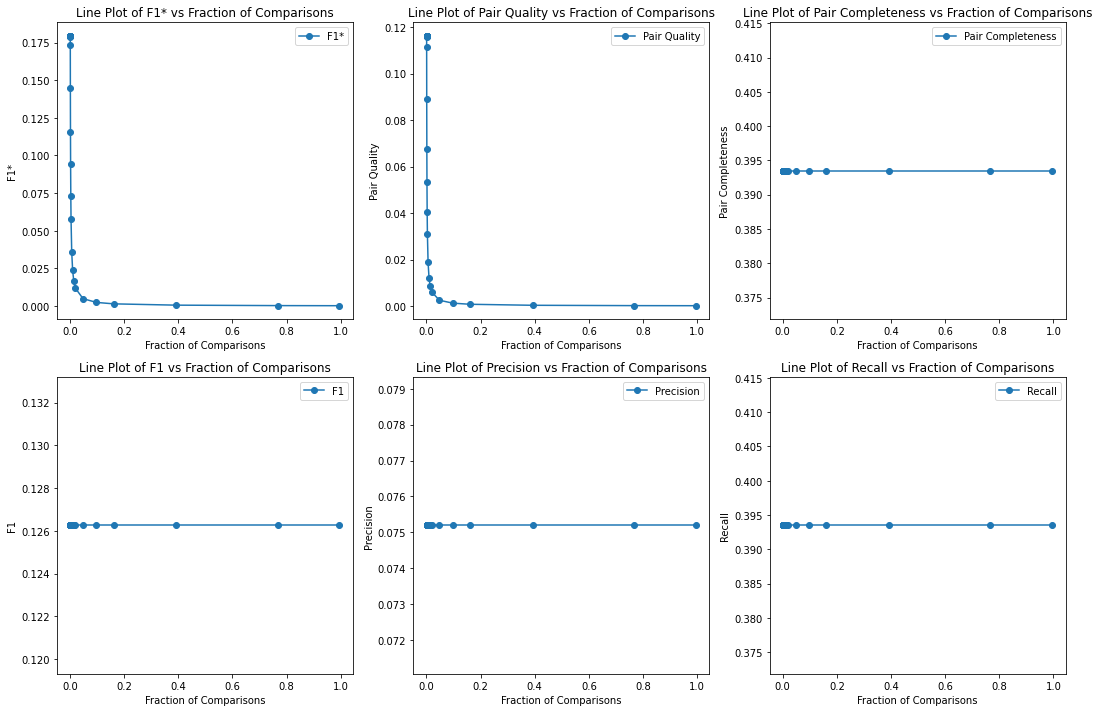

In [475]:
import matplotlib.pyplot as plt
# Now let's create six line plots
performance_measures = ['F1*', 'Pair Quality', 'Pair Completeness', 'F1', 'Precision', 'Recall']
plt.figure(figsize=(15, 10))

# Plot each performance measure
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(x, y[:,i], label=performance_measures[i], marker='o')
    plt.xlabel('Fraction of Comparisons')
    plt.ylabel(performance_measures[i])
    plt.title(f'Line Plot of {performance_measures[i]} vs Fraction of Comparisons')
    plt.legend()
    
plt.tight_layout()
plt.show()

In [479]:
y[:,2]

array([0.39348371, 0.39348371, 0.39348371, 0.39348371, 0.39348371,
       0.39348371, 0.39348371, 0.39348371, 0.39348371, 0.39348371,
       0.39348371, 0.39348371, 0.39348371, 0.39348371, 0.39348371,
       0.39348371, 0.39348371, 0.39348371, 0.39348371, 0.39348371,
       0.39348371, 0.39348371, 0.39348371, 0.39348371, 0.39348371,
       0.39348371, 0.39348371, 0.39348371, 0.39348371, 0.39348371])